#Flood Mapping around Lower Missouri River, USA

#**Project Background**

 Missouri river is the most remarkable stream in the world. It is the longest, the most tortuous, carries the greatest volume of water, and is the most difficult to navigate. From the Three Forks, at Gallatin, Mont., northwest of Yellowstone Park, to the mouth of the river, is a distance of 2547 miles, and from the head of the Jefferson branch to the mouth of the river is a distance of nearly 3000 miles.
The watershed of the Missouri river covers an area of 580,000 square miles, extending from New Mexico to the British possessions and westward to the Rocky Mountains. Within this vast expanse are thousands of streams which flow into the great river. Among the largest, beginning at the head, are the Tetón, Marias, Milk River, Yellowstone. Little Missouri, Knife river.

One of the major caracteristic of the missouri river is flooding. Generally Lower Missouri River sustained three devastating floods within 30 years: 1993, 2011 and 2019. The 2019 flood caused billions of dollars in damages to agriculture and infrastructure in communities in the states of Iowa, Nebraska, Kansas and Missouri.

Researchers have pointed out that the first step towards mitigating floods in the area is isolation of susceptible areas (red zones). In this project, we would use satellite data and Rem to visualized flood prone zones around a section of the river.

# **Library Imports**

In [1]:
pip install osmnx datashader rioxarray xarray-spatial datashader geojson


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 72.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 require

In [2]:
from pathlib import Path
from IPython.core.display import Video

import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import shapely

from shapely.geometry import box
from scipy.spatial import cKDTree as KDTree
import geojson
import xarray as xr
import xrspatial
import rioxarray
import matplotlib.pyplot as plt
from datashader.transfer_functions import shade, stack

In [3]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# **Load DEM data**

In [4]:
data_dir = 'drive/My Drive/Colab Notebooks/USGS_1_n49w106_20130911.tif'
dem = rioxarray.open_rasterio(data_dir)



> Indented block



In [5]:

#Clip DEM for improved focus.
geom = '''{"type": "Polygon",
                "coordinates":[[[-113.1200134754,46.0653853674],
                                [-103.8914978504,46.0653853674],
                                [-103.8914978504,49.2030326585],
                                [-113.1200134754,49.2030326585],
                                [-113.1200134754,46.0653853674]]]}'''

In [6]:
cropping_geometries = [geojson.loads(geom)]
cropped = dem.rio.clip(geometries=cropping_geometries, crs=4326)
cropped = cropped.coarsen(x=8, boundary='trim').mean().coarsen(y=3, boundary='trim').mean()

Time to get a look at the DEM plot

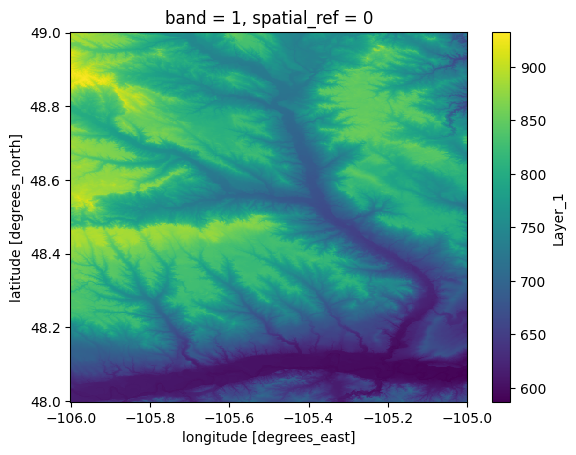

In [7]:
cropped.squeeze().plot.imshow()

Now, lets Isolate our river. First, we get the river coordinates

In [8]:
river = ox.geocode_to_gdf('Missouri River', which_result=1)
river = river.to_crs(cropped.rio.crs)

... and plot ...

<Axes: >

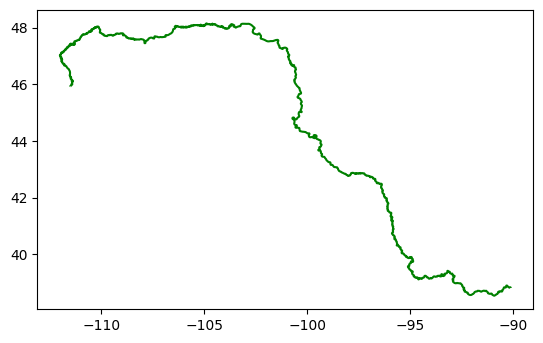

In [10]:
river.plot(color='g')

Based on our bounds, we would now cut the area of interest

In [11]:
cropped.rio.bounds()
bounds = cropped.rio.bounds()
xmin, ymin, xmax, ymax = bounds

river = river.clip(bounds)
river_geom=river.geometry.iloc[0]
#the DEM
cropped = cropped.sel(y=slice(ymax, ymin), x=slice(xmin, xmax))

Lets make a plet to see if these has been implemented

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

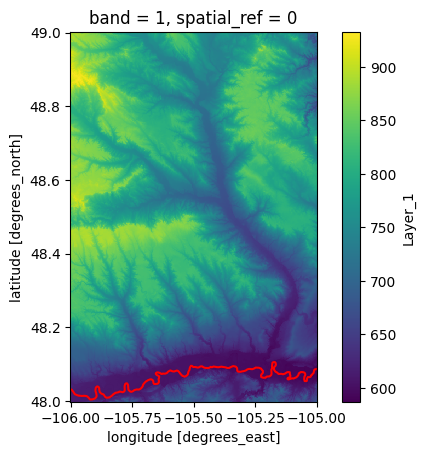

In [12]:
fig, ax = plt.subplots()
cropped.squeeze().plot.imshow(ax=ax)
river.plot(ax=ax, color='red')

Calculation of REM

***To calculate the REM, we following the foregoing steps:***
* Sample the elevation along the river
* Interpolate the sampled elevation values to create a 2D elevation raster
* Subtract the interpolated elevation raster from the DEM

Sampling elevation along the river

In [13]:
#This fuction extracts coordinates as `DataArray`

def split_coords(geom):
    x = []
    y = []
    for i in shapely.get_coordinates(geom):
        x.append(i[0])
        y.append(i[1])
    return x, y


In [14]:
xs, ys = split_coords(river_geom)
xs, ys = xr.DataArray(xs, dims='z'), xr.DataArray(ys, dims='z')

We now use xarray' interpolation function to extract the river's elevation.

In [15]:
sampled = cropped.interp(x=xs, y=ys, method='nearest').dropna(dim='z')

In [16]:
# Sampled river coordinates
c_sampled = np.vstack([sampled.coords[c].values for c in ('x', 'y')]).T

c_x, c_y = [cropped.coords[c].values for c in ('x', 'y')]
c_interpolate = np.dstack(np.meshgrid(c_x, c_y)).reshape(-1, 2)

# Sampled values
values = sampled.values.ravel()

Perform the interpolation.

In [17]:
# IWD interpolation
tree=KDTree(c_sampled)
distances, indices = tree.query(c_interpolate, k=50)

weights = 1 / distances
weights = weights / weights.sum(axis=1).reshape(-1, 1)

interpolated_values = (weights * values[indices]).sum(axis=1)

Now that interpolation is complete, we create a `DataArray` out of the interpolated values

> Indented block



In [18]:
elevation_raster = xr.DataArray(
    interpolated_values.reshape((len(c_y), len(c_x))).T, dims=('x', 'y'), coords={'x': c_x, 'y': c_y}
)

Then plot...

<Axes: xlabel='x', ylabel='y'>

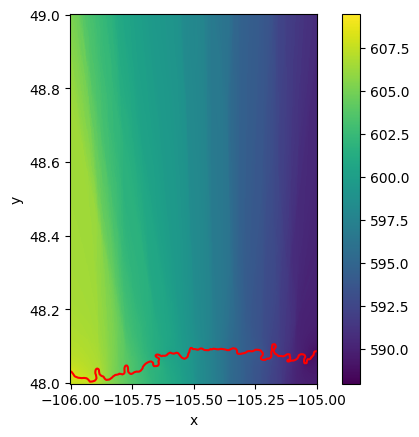

In [19]:
fig, ax = plt.subplots()
elevation_raster.transpose().plot.imshow(ax=ax)
river.plot(ax=ax, color='red')

### Perform the calculation

In [20]:
rem = cropped - elevation_raster

# Step 5: Visualize

Great. Its time to make REM visualizations!

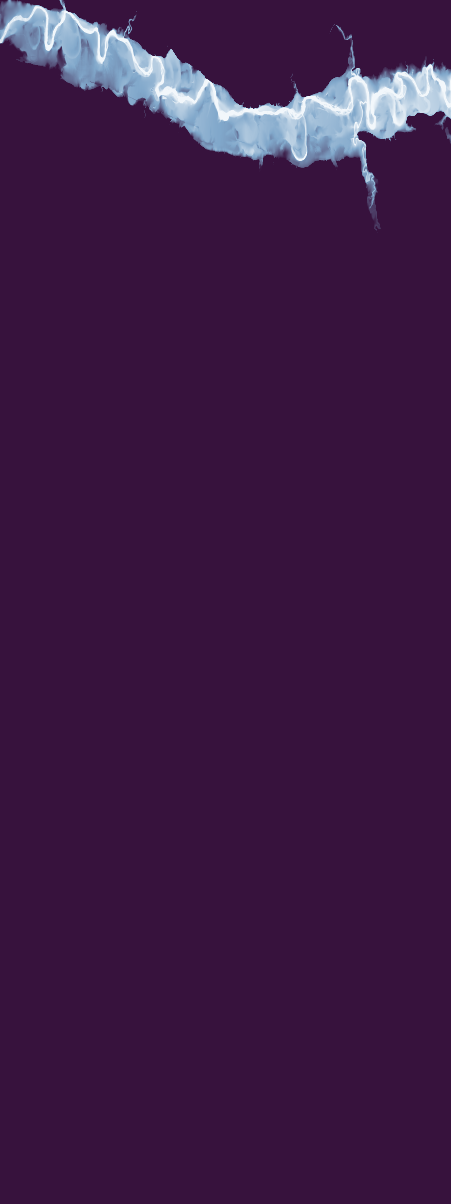

In [21]:
colors = ['#f2f7fb', '#81a8cb', '#37123d']
shade(rem.squeeze(), cmap=colors, span=[0, 10], how='linear')

Then, visualize the DEM along with the REM to appreciate the topography

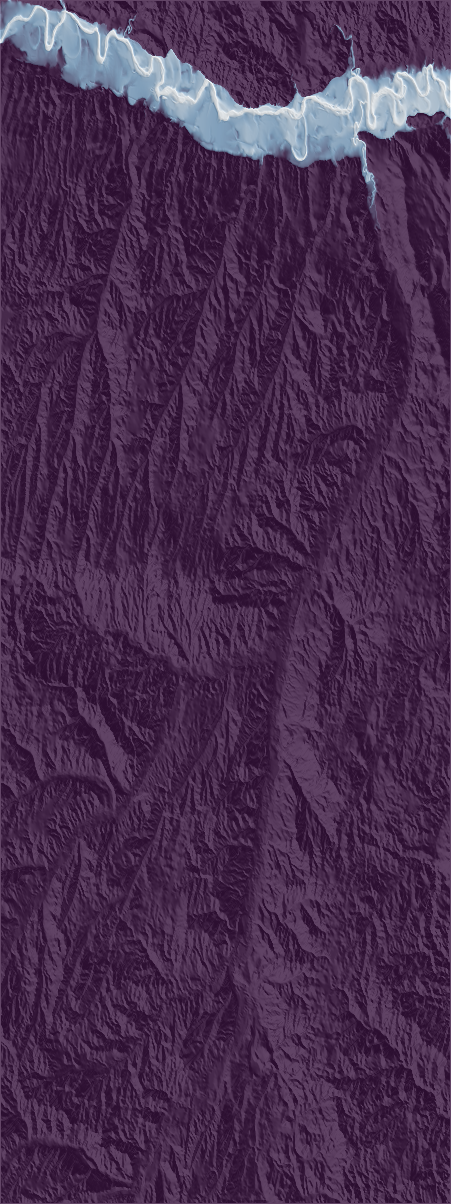

In [22]:
a = shade(xrspatial.hillshade(cropped.squeeze(), angle_altitude=1, azimuth=310), cmap=['black', 'white'], how='linear')
b = shade(rem.squeeze(), cmap=colors, span=[0, 10], how='linear', alpha=200)
stack(a, b)

Analysis:
From the plot, we could see the nature of the river flow as well as the influencing topogramphy around it. Morover, the flood plains which bound the river are visually highlighted.

SyntaxError: ignored